# Overview

In this notebook we will cover the basic concepts for training a specific convolutional neural network architecture known as a U-net in TensorFlow. Using this architecture we are able to estimate boundaries of brain tumor tissue types (e.g. segmentation) from multimodal MR images. The data that we will be using in this tutorial comes from the MICCAI Brain Tumor Segmentation Challenge (BRaTS). More information about he BRaTS Challenge can be found here: http://braintumorsegmentation.org/

For basics of Tensorflow operation, neural networks and training, consider reviewing the preceding lectures in this series:

&nbsp;&nbsp;&nbsp;&nbsp; **01 - Introduction to Data, Tensorflow and Deep Learning** <br/>
&nbsp;&nbsp;&nbsp;&nbsp; **02 - Training a Classifier** <br/>
&nbsp;&nbsp;&nbsp;&nbsp; **03 - Inference with a Classifier**

### U-net

The U-net is a popular network design under the family of encoder-decoder architectures. In this type of architecture, an encoding (collapsing) arm gradually reduces the spatial dimension with pooling layers (or strided convolutions) while a decoding (expanding) arm gradually recovers the object details and spatial dimension. There are usually shortcut connections from encoder to decoder to help decoder recover the object details better. For further reading, see link for original paper (https://arxiv.org/abs/1505.04597) as well as a blog here about different segmentation techniques (http://blog.qure.ai/notes/semantic-segmentation-deep-learning-review).

### Importing modules

To train our simple classifer implementation, we will require three open-source libraries (`tensorflow`, `numpy` and `os`) as well as our custom modules created for this tutorial (`net`, `data`). 

In [0]:
import os, sys
import tensorflow as tf, numpy as np
from IPython.display import Image

sys.path.append('%s/dl_tutorial/code' % os.environ['HOME'])
import net, data

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from IPython.display import Markdown as md
ip = open('../public-ipv4').read() if os.path.exists('../public-ipv4') else '0.0.0.0'

### Hyperparameter variables

Hyperparameters are parameters whose values are set before the learning process begins and which in turn influence and direct the training process. These will be the three most important hyperparameter variables to vary in this experiment. We will cover these in more detail as they are encountered in the code below.

In [0]:
iterations = 200
batch_size = 16
learning_rate = 1e-3

### Preparation

Here we perform some basic preparatory steps including: 

* setting the data root directory 

> If **AWS** or **Google**: `/data/brats/npy`

> If **local**: `../data` (or whichever local directory data is stored in)

* making the output directory for saving training checkpoints and logs
* defining an `ops` dictionary to save operations
* reseting any existing graph that may exist (`tf.reset_default_graph()`)

In [0]:
root = '/data/brats/npy'
output_dir = '%s/dl_tutorial/exp_unet' % os.environ['HOME']
os.makedirs(output_dir, exist_ok=True)
ops = {}
tf.reset_default_graph()

### Data batch

A data **mini-batch** is used to describe the collection of image and label pairs used to perform one update of our network parameters. The more number of images and labels we use for each update, the more likely that update is to reflect the underlying population data. However, the trade-off is that computationally each network update will require more time. A good initial starting point for images matrices of our dataset may be 16 or 32. 

To implement batching, we will use a prepared template method `net.init_batch()` to load a number of slices simulatenously:

In [0]:
batch = net.init_batch(batch_size, root=root)

### Placeholders

A tensorflow **placeholder** is an entry point for us to feed actual data values into the model. We must define this **placeholder** and all subsequent downstream operations performed on this **placeholder** before ever passing data into the model. 

The placeholder `X` will serve as the method for introduction image data into the graph. The placeholder `y` will serve as the method for introducing the correct target label at each voxel location:
```
0 = background (no tumor)
1 = non-enhancing tumor
2 = edema
3 = necrosis
4 = enhancing tumor
```

The placeholder `mask` will serve as a binary mask representing voxels containing non-background data; the utility of masking the loss function will be discussed further below. The placeholder `mode` will serve as a method for introducing whether or not the graph is being executed for training or for validation.

In [0]:
X = tf.placeholder(tf.float32, shape=[None, 240, 240, 4], name='X')
y = tf.placeholder(tf.float32, shape=[None, 240, 240, 5], name='y')
mask = tf.placeholder(tf.float32, shape=[None, 240, 240, 1], name='mask')
mode = tf.placeholder(tf.bool, name='mode')

### Network

In this example we will be using a template U-net created by the `net.create_unet()` method. The encoder arm of the architecture is similar to the classifer from earlier in this tutorial series, implemented by alternating series of convolutions, ReLU non-linearities and max-pooling. In addition a symmetric decoder arm of the architecture uses convolutional-transpose operations to gradually upsample the feature maps and recover high-frequency object details. See below for simplified diagram of network architecture:


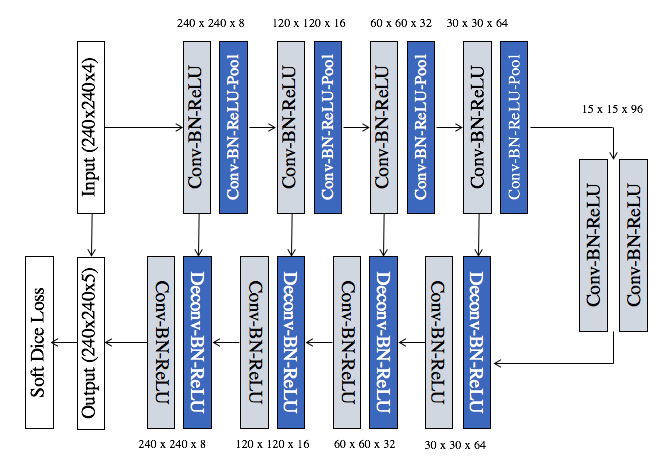

In [6]:
Image('%s/dl_tutorial/code/unet.png' % os.environ['HOME'])


To implement this architecture, simply call the `net.create_unet()` method:

In [0]:
pred = net.create_unet(X, training=mode)

### Masking

Masking the loss function is a technique by which non-important voxels in the output label can be ignored by the algorithm during training. For example, in our data, the background voxels from our brain-extracted images (signal intensity == 0) will never contain tumor. By setting these voxels to zero here in the prediction tensor, they will never contribute to the loss function and thus have a derivative of zero during backprogation. By focusing algorithm learning in this way, overall speed of training can be increased. 

In [0]:
masked_pred = pred * mask
masked_y = y * mask

### Loss and error

Next, based on these prediction logits, we need to give the algorithm feedback whether or not the network is correct. To do so, we will use a modified **Dice** score loss function. Comparision between the true formal definition and our modified approximation are shown here:
```
Dice (formal) = 2 x (y_pred UNION y_true) 
              -------------------------
               | y_pred | + | y_true | 

Dice (approx) = 2 x (y_pred * y_true) + d 
              -------------------------
              | y_pred | + | y_true | + d 
```

Here *d* is small delta == 1e-7 added both to numerator/denominator to prevent division by zero. Note that the approximation is necessary because the true formal Dice score definition is non-differentiable.

To implement a Dice score loss function, we will use the a prepared template function `net.loss_dice()`.

In [0]:
losses = net.loss_dice(masked_pred, masked_y)

### Optimizer

An optimizer is a strategy used to update the network parameters through backprogration by taking into account the quantitative loss function. We will be using the Adam optimizer for our tutorials, an algorithm for first-order gradient-based optimization of stochastic objective functions, based on adaptive estimates of lower-order moments. For further reading, see the following link for the original paper: https://arxiv.org/abs/1412.6980

A key hyperparameter here is the optimizer **learning rate**. The learning rate describes the absolute magnitude of update for each parameter for one iteration. A higher learning rate will result in a correspondingly larger, more aggresive "step" towards the global minimum of a function, however a learning rate that is too high may cause the network to overshoot the true function minimum and even worse, may lead to network instability. A good initial learning rate to use in most experiments, without other guiding heuristics, is `1e-3` which is what we will set our initial `learning_rate` hyperparameter to.

Note that the `tf.control_dependencies()` method here ensures that any other pending graph operations must be complete before the optimizer node is executed.

In [0]:
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.control_dependencies(update_ops):
    global_step = tf.train.get_or_create_global_step()
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    ops['train'] = optimizer.minimize(-losses['dice'], global_step=global_step)

### Collections

After creating the placeholders and predictions, we will add them to named Graph collections for easy retrieval after training is complete during inference.

In [0]:
tf.add_to_collection("inputs", X)
tf.add_to_collection("inputs", mode)
tf.add_to_collection("inputs", mask)
tf.add_to_collection("outputs", pred)

### TensorBoard

TensorBoard is useful utility that can be used to track various statistics during the network training process. Here we set up operations to create log files that can be loaded using the TensorBoard interface

In [0]:
tf.summary.histogram('logits', pred)
tf.summary.scalar('dice-all', losses['dice'])
tf.summary.scalar('dice-background', losses[0])
tf.summary.scalar('dice-nET', losses[1])
tf.summary.scalar('dice-edema', losses[2])
tf.summary.scalar('dice-necrosis', losses[3])
tf.summary.scalar('dice-enhancement', losses[4])
ops['summary'] = tf.summary.merge_all()

# Network training

Now that graph, loss function and optimizer have been configured, it is time to run the training algorithm. To begin we define a new `tf.Session` class and initialize our basic objects to enable saving intermediate checkpoints and writing log data. In addition we initialize `coord` and `thread` objects to handle asynchronous loading of input data into batches:
```
sess, saver, writer_train, writer_valid = net.init_session(sess, output_dir)
```

To perform actual training, we will construct a loop to repeat parameter updates a total of `iteration` times. For each update, we will start by loading the data into batches `X_batch`, `y_batch` and `mask_batch`:
```
X_batch, y_batch, mask_batch = sess.run([batch['train']['X'], batch['train']['y'], batch['train']['mask']])
```

Then we call `sess.run()` to run one iteration of the training process. Specifically we wil request the network to output the tensor variables `losses`, `summary` (used for creating logs) and `step` (global step reflecting total number of iterations). Note that the `ops['train']` operation corresponding to the optimizer node is also called, but there is no output for this function and hence no (`_,`) return variable.
```
 _, metric, summary, step  = sess.run(
                [ops['train'], losses, ops['summary'], global_step],
                feed_dict={
                    X: X_batch, 
                    y: y_batch, 
                    mask: mask_batch,
                    mode: True})
```

Finally, for every 10 updates, will ask the network to run against a separate validation cohort (e.g. completely separate from the training dataset) to track the overall generalization of the algorithm's learned representation:
```
if not i % 10:
    ...
```


This entire training process can be executed by running the following cell:

In [0]:
with tf.Session() as sess:

    sess, saver, writer_train, writer_valid = net.init_session(sess, output_dir)
    print('\n\nTraining Statistics:\n')

    try:
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        metrics = net.init_metrics(losses)

        for i in range(iterations):

            X_batch, y_batch, mask_batch = sess.run([batch['train']['X'], batch['train']['y'], batch['train']['mask']])
            _, metric, summary, step  = sess.run(
                [ops['train'], losses, ops['summary'], global_step],
                feed_dict={
                    X: X_batch, 
                    y: y_batch, 
                    mask: mask_batch,
                    mode: True})

            writer_train.add_summary(summary, step)
            metrics = net.update_ema(metrics, metric, mode='train', iteration=i)
            net.print_status(metrics, step, metric_names=[2, 4])

            # --- Every 10th iteration run a single validation batch
            if not i % 10:

                X_batch, y_batch, mask_batch = sess.run([batch['valid']['X'], batch['valid']['y'], batch['valid']['mask']])
                metric, summary = sess.run(
                    [losses, ops['summary']],
                    feed_dict={
                        X: X_batch, 
                        y: y_batch, 
                        mask: mask_batch,
                        mode: False})

                writer_valid.add_summary(summary, step)
                metrics = net.update_ema(metrics, metric, mode='valid', iteration=i)
                net.print_status(metrics, step, metric_names=[2, 4])

        saver.save(sess, '%s/checkpoint/model.ckpy' % output_dir)

    finally:
        coord.request_stop()
        coord.join(threads)
        saver.save(sess, '%s/checkpoint/model.ckpy' % output_dir)



Training Statistics:



In the above space you will see updates of algorithm training status including number of iterations and errors on both the training and validation set data.

# TensorBoard 

### Overview

TensorBoard is a suite of web applications for inspecting and understanding your TensorFlow runs and graphs. To use Tensorboard, you must embed specialized `tf.summary.*` operations into your graph which produce serialized protobufs that track various training statistics over time. The supported summary ops include:

* tf.summary.scalar
* tf.summary.image
* tf.summary.audio
* tf.summary.text
* tf.summary.histogram

During the training process, a specialized `summary.FileWriters()` class is used to take summary data created by `tf.summary.*` operations and write them to a specified directory, known as the `logdir`. This was implemented in following line of code above:
```
writer_valid.add_summary(summary, step)
```

### Launching TensorBoard

To launch TensorBoard, run the following command:

In [0]:
!pkill -9 tensorboard
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(output_dir)
)


Note, this is equivalent to the following Terminal command:
```
tensorboard --logdir={output_dir} --host 0.0.0.0 --port 6006
```

To launch the TensorBoard session, open up a new tab in your browser and type in the following address pattern:
```
[IP-address]:6006
```

Where `[IP-address]` is the same address of form `xxx.xxx.xxx.xxx` that represents the IP address of your AWS instance. It should be the same prefix as your Jupyter notebook in the address bar currently at the top of your screen. For example, if the IP address is `34.215.158.68`, then the URL entered into the web browser is `34.215.158.68:6006`.

Alternatively, the following lines of code can be used for convience:

For **AWS instance** use the following Markdown text:

In [0]:
md('**Tensorboard URL** (right-click > open in new tab): [http://%s:6006](http://%s:6006)' % (ip, ip))

For **Google Colaboratory** use the following ngrok commands:

In [0]:
!pkill -9 ngrok
get_ipython().system_raw('./ngrok http 6006 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"


For more information about TensorBoard usage, see link: https://github.com/tensorflow/tensorboard.

### Final thoughts

Feel free to continue training the algorithm until convergence at reasonable accuracy. Once complete, turn off the kernel (top menu > `Kernel` > `Shutdown`; you can keep this tab open in your browser to retrain later) so that it's resources can be used in the next notebook. You are now ready to move on the **05 - Inference with a U-net** to use the newly trained network on data.